In [67]:
import librosa 
import matplotlib.pyplot as plt
import numpy as np
import pretty_midi
import os
from tqdm import tqdm

# CQT Configuration 
hop_length_sec = 0.01               # 10 ms
fmin = librosa.note_to_hz('A0')     # Start at A0 (piano)
bins_per_octave = 36                # 3 bins per semitone
n_bins = 267                        # Covers A0 to C8
sr = 22050
hop_length = int(hop_length_sec * sr)

def plot_cqt_with_pianoroll(audio_path, midi_path):
    cqt_list = []
    y, _ = librosa.load(audio_path, sr=sr)

    C = librosa.cqt(
        y, sr=sr,
        hop_length=hop_length,
        fmin=fmin,
        n_bins=n_bins,
        bins_per_octave=bins_per_octave
    )
    C_dB = librosa.amplitude_to_db(np.abs(C), ref=np.max)

    # Load MIDI and get piano roll
    midi_data = pretty_midi.PrettyMIDI(midi_path)
    fs_pianoroll = sr / hop_length  # Frame rate to match CQT
    piano_roll = midi_data.get_piano_roll(fs=fs_pianoroll)

    # Align time axes
    n_frames = min(C_dB.shape[1], piano_roll.shape[1])
    C_dB = C_dB[:, :n_frames]
    piano_roll = piano_roll[:, :n_frames]
    cqt_list.append(C_dB)
    return C_dB, piano_roll



In [84]:
audio_path = 'gen_audio'
midi_path = 'gen_piano'

num_sample =2
cqt_list = []
piano_list = []

for i in tqdm(range(1,num_sample)):
    if i:
        audio = os.path.join(audio_path, f'all-harmonic-intervals-{i}.mp3')
        midi = os.path.join(midi_path, f'all_harmonic_intervals_{i}.mid')
        cqt , piano = plot_cqt_with_pianoroll(audio, midi)
        cqt_list.append(cqt)
        piano_list.append(piano)
cqt_concat = np.concatenate(cqt_list, axis=1)  # along time axis
piano_concat = np.concatenate(piano_list, axis=1)

100%|██████████| 1/1 [00:07<00:00,  7.09s/it]


In [85]:
print(cqt_concat.shape,"\n",piano_concat.shape)

(267, 16532) 
 (128, 16532)


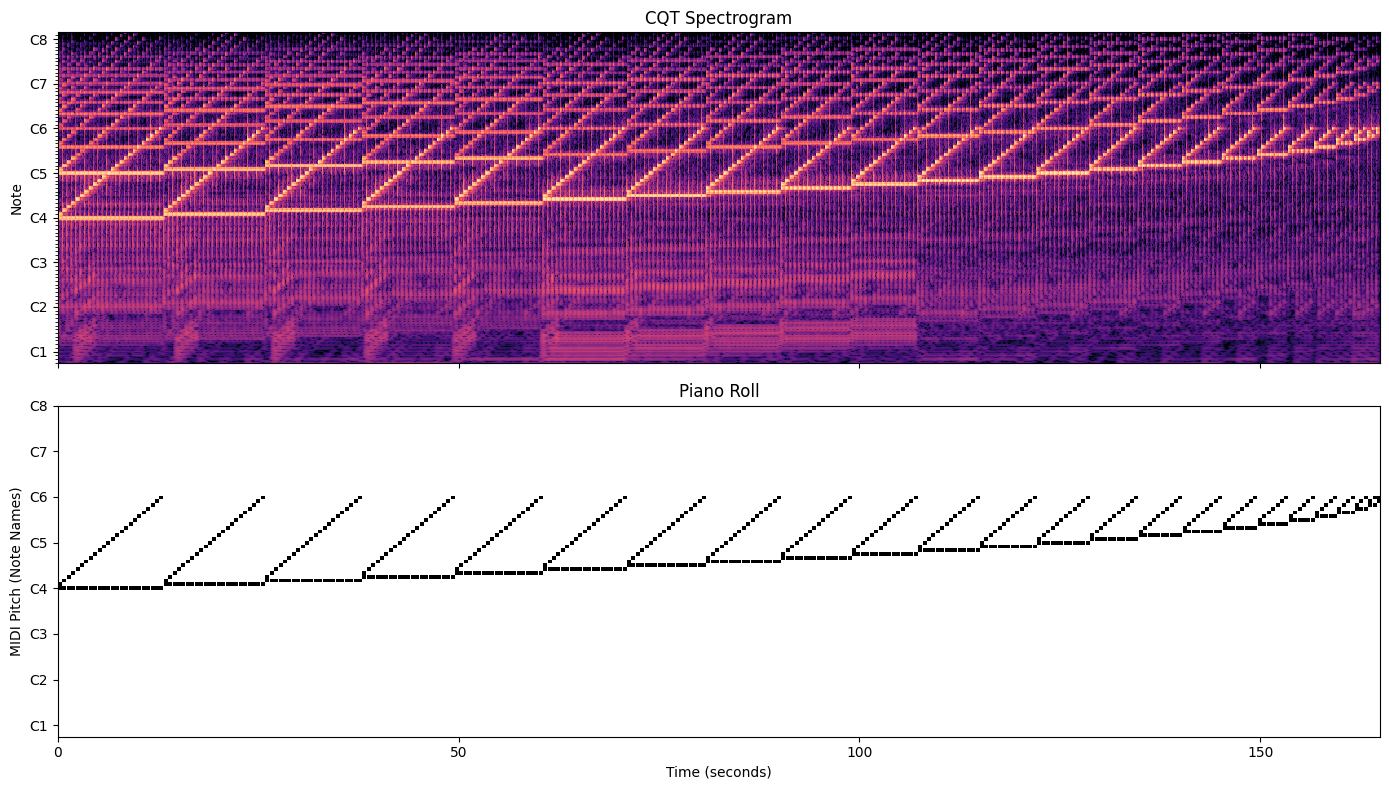

In [86]:
duration_sec = piano_concat.shape[1] * hop_length / sr

# Plot setup
fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Plot CQT 
librosa.display.specshow(
    cqt_concat[:,:],
    sr=sr,
    hop_length=hop_length,
    x_axis='s',                  
    y_axis='cqt_note',
    fmin=fmin,
    bins_per_octave=bins_per_octave,
    cmap='magma',
    ax=axs[0]
)
axs[0].set_title("CQT Spectrogram")
axs[0].label_outer()  

# Plot Piano Roll
pitch_min = 21
pitch_max = 108

axs[1].imshow(
    piano_concat[pitch_min:pitch_max+1, :],
    aspect='auto',
    origin='lower',
    cmap='gray_r',
    interpolation='nearest',
    extent=[0, duration_sec, pitch_min, pitch_max]
)

axs[1].set_xlabel('Time (seconds)')
axs[1].set_ylabel('MIDI Pitch (Note Names)')
axs[1].set_title('Piano Roll')
axs[1].set_ylim(pitch_min, pitch_max)

# Label only natural C notes
c_notes = [n for n in range(pitch_min, pitch_max+1)
           if pretty_midi.note_number_to_name(n).startswith('C') and '#' not in pretty_midi.note_number_to_name(n)]
axs[1].set_yticks(c_notes)
axs[1].set_yticklabels([pretty_midi.note_number_to_name(n) for n in c_notes])

plt.tight_layout()
plt.show()


In [71]:


def create_sliding_windows(cqt, window_size=9, stride=1):
    pad = window_size // 2
    cqt_padded = np.pad(cqt, ((0, 0), (pad, pad)), mode='edge')
    num_time_bins = cqt.shape[1]

    windows = np.array([
        cqt_padded[:, i:i + window_size]
        for i in range(0, num_time_bins, stride)
    ])
    
    return windows[..., np.newaxis] 

def create_sliding_windows_midi(midi, window_size=9, stride=1):
    pad = window_size // 2
    midi_padded = np.pad(midi, ((0, 0), (pad, pad)), mode='constant', constant_values=0)
    num_time_bins = midi.shape[1]

    windows = np.array([
        midi_padded[:, i:i + window_size]
        for i in range(0, num_time_bins, stride)
    ])
    
    return windows, len(windows)

In [72]:
X_input = create_sliding_windows(cqt_concat, window_size=9, stride=1)  # (num_windows, 267, 9, 1)
print("Sliding Window Output Shape:", X_input.shape)

Y_output, num_windows_midi = create_sliding_windows_midi(piano_concat, window_size=9, stride=1)
print("Sliding Window MIDI Output Shape:", Y_output.shape)

Sliding Window Output Shape: (33064, 267, 9, 1)
Sliding Window MIDI Output Shape: (33064, 128, 9)


In [80]:
Y_output_flattened = np.max(Y_output, axis=2) > 70  # Shape: (n, 128)

print("Xtrain : ",X_input.shape)
print("out : ",Y_output.shape)
print("Ytrain : ",Y_output_flattened.shape)

Xtrain :  (33064, 267, 9, 1)
out :  (33064, 128, 9)
Ytrain :  (33064, 128)


In [81]:
# librosa.display.specshow(cqt_concat[:, :100], sr=sr, hop_length=hop_length,
#                             x_axis='time', y_axis='cqt_note',
#                             fmin=fmin, bins_per_octave=bins_per_octave,
#                             cmap='magma')


In [82]:
import tensorflow as tf
num_classes = 128
import datetime


log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Create the callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(10, (16, 2), activation='relu', padding='valid', input_shape=(267, 9, 1), name="conv1"),
    tf.keras.layers.MaxPooling2D((2, 1), name="pool1"),
    tf.keras.layers.Conv2D(20, (11, 3), activation='relu', padding='valid', name="conv2"),
    tf.keras.layers.MaxPooling2D((2, 1), name="pool2"),
    tf.keras.layers.Flatten(name="flatten"),
    tf.keras.layers.Dense(256, activation='relu', name="fc1"),
    tf.keras.layers.Dropout(0.5, name="dropout"),
    tf.keras.layers.Dense(num_classes, activation='sigmoid', name="fc2")
])

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

c:\Users\napat\Documents\GitHub\env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 252, 8, 10)     │           330 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 126, 8, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 116, 6, 20)     │         6,620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 58, 6, 20)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6960)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 256)            │     1,782,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 128)            │        32,896 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,821,862 (6.95 MB)

 Trainable params: 1,821,862 (6.95 MB)

 Non-trainable params: 0 (0.00 B)

In [83]:
model.fit(X_input, Y_output_flattened, 
          epochs=50, 
          batch_size=256,
          validation_split=0.2,
          callbacks=[tensorboard_callback]
          )
model.save("interval.h5")

Epoch 1/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.0711 - loss: 0.5918 - val_accuracy: 0.5938 - val_loss: 0.0122
Epoch 2/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.5924 - loss: 0.0213 - val_accuracy: 0.5645 - val_loss: 0.0035
Epoch 3/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.5907 - loss: 0.0081 - val_accuracy: 0.5042 - val_loss: 0.0022
Epoch 4/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.5750 - loss: 0.0056 - val_accuracy: 0.5002 - val_loss: 0.0015
Epoch 5/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.5703 - loss: 0.0041 - val_accuracy: 0.5072 - val_loss: 0.0011
Epoch 6/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.5701 - loss: 0.0034 - val_accuracy: 0.5143 - val_loss: 8.3577e-04
Epoch 7/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.5651 - loss: 0.0028 - val_accuracy: 0.5429 - val_loss: 7.6247e-04
Epoch 8/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.5549 - loss: 0.0022 - 